In [165]:
import numpy as np
import cv2
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from skimage.morphology import skeletonize
from skimage.util import invert
from scipy.interpolate import interp1d
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import root_mean_squared_error
from scipy.fft import fft, fftfreq

In [166]:
def load_binary_image(image_path, crop_top=0, crop_bottom=0):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) #image to grayscale
    image=image[crop_top:crop_bottom]
    _, binary_image = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY) #grayscale to binary
    return binary_image

In [167]:
get_img = invert(load_binary_image('photo12.jpeg', 150,190))

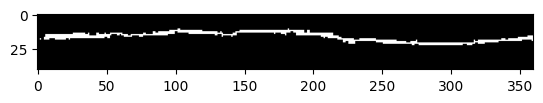

In [168]:
plt.imshow(get_img, cmap='gray')

In [169]:
blur = cv2.GaussianBlur(get_img, (5,5),0)

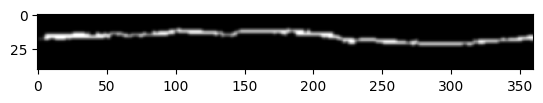

In [170]:
plt.imshow(blur, cmap='gray')

In [171]:
kernel = np.ones((1, 5), np.uint8)
closed = cv2.morphologyEx(blur, cv2.MORPH_CLOSE, kernel)
opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)

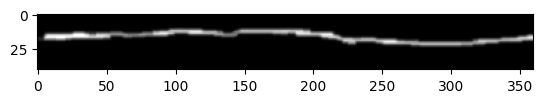

In [172]:
plt.imshow(opened, cmap='gray')

In [173]:
get_skeleton = skeletonize(opened).astype(np.uint8)

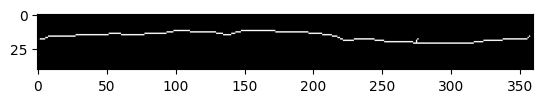

In [174]:
plt.imshow(get_skeleton, cmap='gray')

In [175]:
def extract_points_from_image(binary_image):

    points = np.argwhere(binary_image > 0)
 
    x = points[..., 1]
    y = points[..., 0] 
    sort_idx = np.argsort(x)
    x = x[sort_idx]
    y = y[sort_idx]
    return x, y

In [176]:
x_points,y_points = extract_points_from_image(get_skeleton)

In [177]:
x_points

array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 18

In [178]:
y_points

array([18, 18, 18, 18, 17, 17, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 13, 13, 13, 13, 13, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 14, 14, 14, 13, 13, 13, 13, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 17, 17, 18, 18, 19,
       19, 19, 19, 19, 19

In [179]:
def endless_mirroring(x,y, n_periods):
    len_original = len(y)
    
    y_mirrored = np.concatenate([y, y[-2::-1]])

    len_period = len(y_mirrored)
    
    y_periodic = np.tile(y_mirrored, n_periods)

    x_extended = x[0] +  np.arange(len(y_periodic))

    return x_extended, y_periodic

In [180]:
x_inf, y_inf = endless_mirroring(x_points, y_points, n_periods=10)

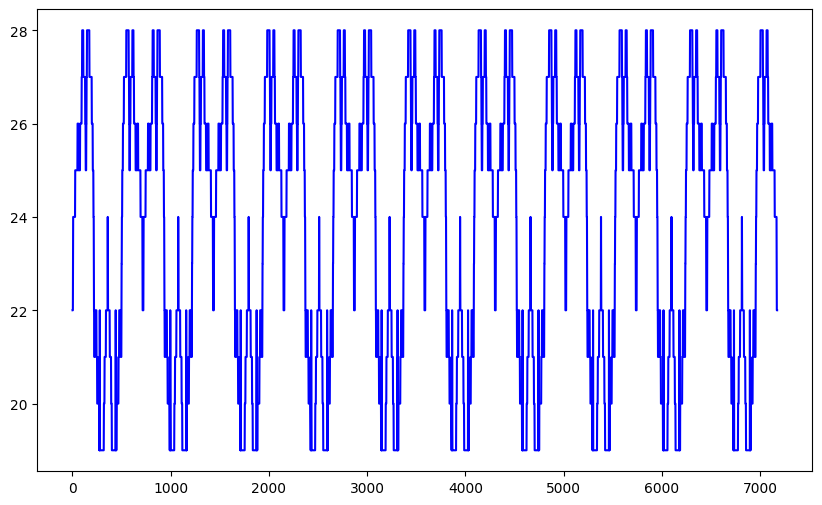

In [181]:
plt.figure(figsize=(10, 6))
height = get_img.shape[0]
plt.plot(x_inf, height - y_inf, color='blue', label='Исходные точки')

/var/folders/5x/5z67klg92k997tvr4jjj1tt80000gn/T/ipykernel_66594/3937574430.py:21: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fourier_series, x_norm, y_inf, p0=initial_guess, maxfev=10000)


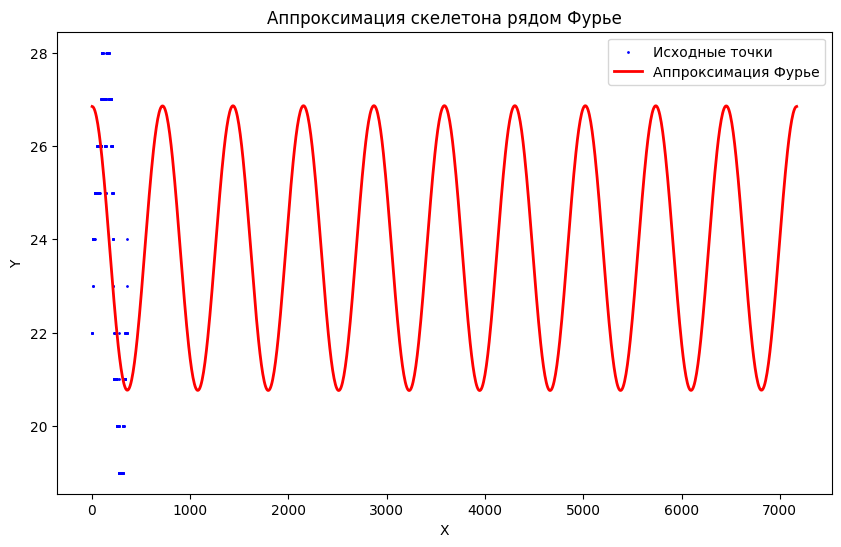

Коэффициенты ряда Фурье:
a0 = 16.187313191103513
a1 = 7.455242674747655e-17, b1 = 0.0008535449497446372
a2 = 8.956184857891677e-18, b2 = 0.00087496368514387
a3 = -2.45863594494357e-16, b3 = 0.0009144441591649172
a4 = 1.6072327022084028e-16, b4 = 0.0009790948954474894
a5 = 1.7049751509676104e-17, b5 = 0.0010829734111757478
a6 = -2.0725491222514944e-16, b6 = 0.0012553371384326191
a7 = 4.1910780728895373e-17, b7 = 0.001565966071569065
a8 = 1.4618668467459734e-16, b8 = 0.0022264972399920033
a9 = 6.420770283346207e-17, b9 = 0.004301623529109853
a10 = 1.2168073077797564e-16, b10 = -3.0496201847758764


In [182]:
#Ограниченный ряд фурье
def fourier_series(x, *params):
    y = params[0] * np.ones_like(x)
    for i in range(1, len(params)//2 + 1):
        n = i
        ai = params[2*i-1] if (2*i-1) < len(params) else 0
        bi = params[2*i] if 2*i < len(params) else 0
        y += ai * np.sin(2 * np.pi * n * x / max(x)) + bi * np.cos(2 * np.pi * n * x / max(x))
    return y

# Normalize x
scaler = MinMaxScaler()
x_norm = scaler.fit_transform(x_inf.reshape(-1, 1)).flatten()


num_harmonics = 10

initial_guess = [np.mean(y_points)] + [0] * 2 * num_harmonics


popt, pcov = curve_fit(fourier_series, x_norm, y_inf, p0=initial_guess, maxfev=10000)


x_smooth = np.linspace(min(x_norm), max(x_norm), 1000)
y_smooth = fourier_series(x_smooth, *popt)

# Обратное преобразование x для отображения в оригинальных координатах
x_smooth_orig = scaler.inverse_transform(x_smooth.reshape(-1, 1)).flatten()
#Переворачиваем график
height = get_img.shape[0]
# Визуализация
plt.figure(figsize=(10, 6))
plt.scatter(x_points, height - y_points, s=1, color='blue', label='Исходные точки')
plt.plot(x_smooth_orig, height - y_smooth, color='red', linewidth=2, label='Аппроксимация Фурье')

plt.legend()
plt.title('Аппроксимация скелетона рядом Фурье')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Вывод коэффициентов
print("Коэффициенты ряда Фурье:")
print(f"a0 = {popt[0]}")
for i in range(1, len(popt)//2 + 1):
    print(f"a{i} = {popt[2*i-1] if (2*i-1) < len(popt) else 0}, b{i} = {popt[2*i] if 2*i < len(popt) else 0}")


In [183]:
def adjusted_r2(y_true, y_pred, n_params):
    n = len(y_true)
    r2 = r2_score(y_true, y_pred)
    return 1 - ( (1 - r2) * (n - 1) ) / (n - n_params - 1 )

In [184]:
def nrmse(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    y_range = np.max(y_true) - np.min(y_true)
    return 1- (rmse / y_range)  

In [185]:
y_pred = fourier_series(x_norm, *popt)
r2 = r2_score(y_points, y_pred)
adj_r2 = adjusted_r2(y_points, y_pred, num_harmonics * 2 + 1)
cos_sim = cosine_similarity(y_points.reshape(-1,1),y_pred.reshape(-1,1))[0][0]
normmse = nrmse(y_points,y_pred)

print(f"R2 = {r2:.4f}")
print(f"adjusted R2 = {adj_r2:.4f}") #promising
print(f"Cos simil = {cos_sim:.4f}")
print(f"NRMSE = {normmse:.4f}") #promising

ValueError: Found input variables with inconsistent numbers of samples: [359, 7170]

In [ ]:
def single_sin(x, A, freq, phase, offset):
    return A * np.sin(2 * np.pi * freq * x + phase) + offset


In [ ]:
def find_optimal_split(x, y, min_points=10):
    best_nrmse = -np.inf
    best_split = x[len(x)//2]  # Начальное значение — середина
    
    for i in range(min_points, len(x)-min_points):
        split = x[i]
        mask = x < split
        
        # Подгоняем синусоиды для левой и правой частей
        try:
            params_left, _ = curve_fit(single_sin, x[mask], y[mask], p0=[1, 0.1, 0, np.mean(y[mask])])
            params_right, _ = curve_fit(single_sin, x[~mask], y[~mask], p0=[1, 0.1, 0, np.mean(y[~mask])])
            
            y_pred = np.concatenate([
                single_sin(x[mask], *params_left),
                single_sin(x[~mask], *params_right)
            ])
            
            current_nrmse = nrmse(y, y_pred)
            if current_nrmse > best_nrmse:
                best_nrmse = current_nrmse
                best_split = split
        except:
            continue
    
    return x[best_split], best_nrmse

In [ ]:
def double_sin(x, A1, freq1, phase1, A2, freq2, phase2, offset, split_point=find_optimal_split(x_points,y_points)[0]):

    mask = x < split_point/len(x)
    y = np.zeros_like(x)
    y[mask] = A1 * np.sin(2 * np.pi * freq1 * x[mask] + phase1)
    y[~mask] = A2 * np.sin(2 * np.pi * freq2 * x[~mask] + phase2)
    return y + offset

In [ ]:
len(x_norm)

347

In [ ]:
def fit_two_sin(x,y, threshold =0.95): 
    current_nrmse = 0
    models = []
    params, _ = curve_fit(single_sin, x, y, p0=[1, 0.1, 0, np.mean(y)])
    y_pred = single_sin(x, *params)
    current_nrmse = nrmse(y,y_pred)
    models.append(("Single Sin", params, current_nrmse))
    

    if current_nrmse < threshold: 
        params, _ =  curve_fit(double_sin, x,y, p0=[1, 0.1, 0, 1, 0.1, 0, np.mean(y)])
        y_pred = double_sin(x, *params)
        current_nrmse = nrmse(y,y_pred)
        models.append(("Double Sin (Split)", params, current_nrmse))

    best_model = models[-1]  # (name, params, nrmse)
    return best_model


In [ ]:
best_model_name, best_params, best_nrmse = fit_two_sin(x_norm, y_points)

print(f"\nЛучшая модель: {best_model_name}")
print(f"Параметры: {best_params}")
print(f"NRMSE = {best_nrmse: .4f}")




Лучшая модель: Double Sin (Split)
Параметры: [ 4.31393823 -1.56798648  2.42878359 10.47375688  0.94234258 -3.33109769
 78.20123451]
NRMSE =  0.9451


In [ ]:
def sin1(x, A1, phi1, C1):
    return A1 * np.sin(2 * np.pi * x / 360 + phi1) + C1

def sin2(x, A2, phi2, C2):
    return A2 * np.sin(2 * np.pi * x / 360 + phi2) + C2

In [ ]:
params1, _ = curve_fit(sin1, x_points, y_points, p0=[1.0,0.0,np.mean(y_points)])

In [ ]:
A1, phi1, C1 = params1

In [ ]:
params2, _ = curve_fit(sin2, x_points, y_points, p0=[0.5,45,np.mean(y_points)])

In [ ]:
# Grid Search для второй синусоиды
def find_distinct_sin2(x, y, A1, phi1, C1, grid_size=10):
    best_nrmse = np.inf
    best_params = None
    
    # Сетка параметров
    A_grid = np.linspace(0.5 * A1, 2 * A1, grid_size)
    phi_grid = np.linspace(0, 180, grid_size)  # Перебираем фазы от 0° до 180°
    C_grid = np.linspace(np.min(y), np.max(y), grid_size)
    
    for A2 in A_grid:
        for phi2 in phi_grid:
            for C2 in C_grid:
                y_pred = sin2(x, A2, phi2, C2)
                current_nrmse = nrmse(y, y_pred)
                
                # Проверяем, что параметры достаточно отличаются от sin1
                is_distinct = (np.abs(A2 - A1) > 0.1 * np.abs(A1)) or \
                             (np.abs(phi2 - phi1) > 30)  # Разница > 30°
                
                if current_nrmse < best_nrmse and is_distinct:
                    best_nrmse = current_nrmse
                    best_params = (A2, phi2, C2)
    
    return best_params, best_nrmse


In [ ]:
params2, nrmse2 = find_distinct_sin2(x_points, y_points, A1, phi1, C1)

In [ ]:
params2

(-13.158219954459078, 40.0, 89.0)

In [ ]:

A2, phi2, C2 = params2

In [ ]:
def adaptive_sinusoid(x, y, window_size=100):
    n = len(x)
    result = np.zeros(n)
    
    for i in range(0, n, window_size):
        start = i
        end = min(i + window_size, n)
        x_window = x[start:end]
        y_window = y[start:end]
        
        
        y1 = sin1(x_window, A1, phi1, C1)
        y2 = sin2(x_window, A2, phi2, C2)
        
        mse1 = np.mean((y1 - y_window) ** 2)
        mse2 = np.mean((y2 - y_window) ** 2)
        
        if mse1 < mse2:
            result[start:end] = y1
        else:
            result[start:end] = y2
    
    return result

In [ ]:
sin1(x_points, A1, phi1, C1);

In [ ]:
hybrid_signal = adaptive_sinusoid(x_points,y_points)

In [ ]:
def evaluate_models(x, y, threshold=0.9):

    models = []
    
    # Модель 1: Только sin1
    y_pred1 = sin1(x, A1, phi1, C1)
    nrmse1 = nrmse(y, y_pred1)
    models.append({
        'name': 'sin1',
        'params': {'A1': A1, 'phi1': phi1, 'C1': C1},
        'nrmse': nrmse1
    })
    
    # Модель 2: Только sin2
    y_pred2 = sin2(x, A2, phi2, C2)
    nrmse2 = nrmse(y, y_pred2)
    models.append({
        'name': 'sin2',
        'params': {'A2': A2, 'phi2': phi2, 'C2': C2},
        'nrmse': nrmse2
    })
    # Модель 3: Адаптивная (sin1 или sin2)
    if nrmse1 < threshold or nrmse2 < threshold:
        y_pred_adaptive = adaptive_sinusoid(x, y)
        nrmse_adaptive = nrmse(y, y_pred_adaptive)
        models.append({
            'name': 'adaptive',
            'params': {
                'sin1': {'A1': A1, 'phi1': phi1, 'C1': C1},
                'sin2': {'A2': A2, 'phi2': phi2, 'C2': C2}
            },
            'nrmse': nrmse_adaptive
        })

        return models

In [ ]:
model_results = evaluate_models(x_points, y_points)
for model in model_results:
    print(f"Модель: {model['name']}")
    print(f"Параметры: {model['params']}")
    print(f"NRMSE: {model['nrmse']:.4f}")
    print("---")

Модель: sin1
Параметры: {'A1': -6.579109977229539, 'phi1': 5.534158744443656, 'C1': 81.4151434582662}
NRMSE: 0.8966
---
Модель: sin2
Параметры: {'A2': -13.158219954459078, 'phi2': 40.0, 'C2': 89.0}
NRMSE: -0.0123
---
Модель: adaptive
Параметры: {'sin1': {'A1': -6.579109977229539, 'phi1': 5.534158744443656, 'C1': 81.4151434582662}, 'sin2': {'A2': -13.158219954459078, 'phi2': 40.0, 'C2': 89.0}}
NRMSE: 0.8966
---


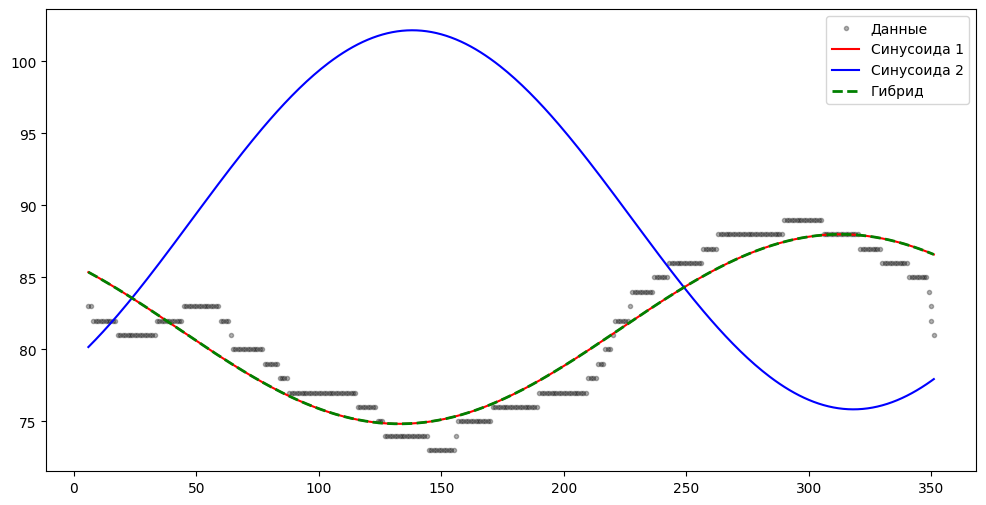

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(x_points, y_points, 'k.', alpha=0.3, label="Данные")
plt.plot(x_points, sin1(x_points, A1, phi1, C1), 'r-', label="Синусоида 1")
plt.plot(x_points, sin2(x_points, A2, phi2, C2), 'b-', label="Синусоида 2")
plt.plot(x_points, hybrid_signal, 'g--', lw=2, label="Гибрид")
plt.legend()
plt.show()
